In [159]:
import os
import librosa
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
!pip install python_speech_features 
from python_speech_features import mfcc  
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout
from keras.models import Sequential

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [160]:
#import google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [161]:
# Step 1: Data collection
df = pd.read_csv('/content/drive/MyDrive/Dataset_drive/train.csv')
df.head()

,fname,label,manually_verified
0,00044347.wav,Hi-hat,0
1,001ca53d.wav,Saxophone,1
2,002d256b.wav,Trumpet,0
3,0033e230.wav,Glockenspiel,1
4,00353774.wav,Cello,1


In [162]:
# Take 5 classes from the dataset
df = df[df['label'].isin(['Saxophone','Acoustic_guitar','Bass_drum', 'Clarinet','Violin_or_fiddle'])]
display(df)


,fname,label,manually_verified
1,001ca53d.wav,Saxophone,1
8,004ad66f.wav,Clarinet,0
30,00fcbab2.wav,Bass_drum,0
38,013c3135.wav,Clarinet,0
40,015cf474.wav,Clarinet,0
...,...,...,...
9430,ff0c153b.wav,Saxophone,1
9433,ff11628d.wav,Bass_drum,1
9434,ff12dece.wav,Saxophone,1
9442,ff55a1e2.wav,Acoustic_guitar,0


In [163]:
df2 = df[df['label'].isin(['Violin_or_fiddle'])]
display(df2)

,fname,label,manually_verified
140,04186a03.wav,Violin_or_fiddle,1
149,044be615.wav,Violin_or_fiddle,1
170,04e8596a.wav,Violin_or_fiddle,0
182,0556be76.wav,Violin_or_fiddle,1
196,05ecefbe.wav,Violin_or_fiddle,0
...,...,...,...
9315,fba51845.wav,Violin_or_fiddle,1
9355,fcbf1b7d.wav,Violin_or_fiddle,0
9357,fcd11bc8.wav,Violin_or_fiddle,1
9377,fd688f3d.wav,Violin_or_fiddle,1


In [164]:
df3 = df[df['label'].isin(['Bass_drum'])]
display(df3)
len(df3)

,fname,label,manually_verified
30,00fcbab2.wav,Bass_drum,0
61,01c2f88b.wav,Bass_drum,1
83,024c4c6d.wav,Bass_drum,1
136,03fc1f96.wav,Bass_drum,1
169,04e82f46.wav,Bass_drum,0
...,...,...,...
9218,f93011d2.wav,Bass_drum,0
9263,fa65b546.wav,Bass_drum,0
9316,fbb6233a.wav,Bass_drum,0
9319,fbc6a343.wav,Bass_drum,1


300

In [165]:
df4 = df[df['label'].isin(['Acoustic_guitar'])]
display(df4)
len(df4)

,fname,label,manually_verified
117,0356dec7.wav,Acoustic_guitar,1
194,05d81cdf.wav,Acoustic_guitar,0
252,0730a3d8.wav,Acoustic_guitar,0
303,08a68ba1.wav,Acoustic_guitar,1
326,0969b5c5.wav,Acoustic_guitar,0
...,...,...,...
9338,fc55d588.wav,Acoustic_guitar,1
9350,fca6de7c.wav,Acoustic_guitar,0
9359,fceb6212.wav,Acoustic_guitar,1
9391,fddb09fd.wav,Acoustic_guitar,0


300

In [166]:
df5 = df[df['label'].isin(['Saxophone'])]
display(df5)
len(df5)

,fname,label,manually_verified
1,001ca53d.wav,Saxophone,1
188,05b76c07.wav,Saxophone,0
195,05e4028a.wav,Saxophone,1
216,06789937.wav,Saxophone,1
235,06f60188.wav,Saxophone,1
...,...,...,...
9365,fd16747a.wav,Saxophone,1
9398,fe136f34.wav,Saxophone,0
9428,ff038671.wav,Saxophone,1
9430,ff0c153b.wav,Saxophone,1


300

In [167]:
# Loading data
path = '/content/drive/MyDrive/Dataset_drive/audio_train/'
audio_data = list()
for i in tqdm(range(df.shape[0])):
    audio_data.append(librosa.load(path+df['fname'].iloc[i]))
audio_data = np.array(audio_data)

100%|██████████| 1500/1500 [05:12<00:00,  4.80it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


In [168]:
# Put the loaded data into data frame
df['audio_waves'] = audio_data[:,0]
df['samplerate'] = audio_data[:,1]
df.head()

,fname,label,manually_verified,audio_waves,samplerate
1,001ca53d.wav,Saxophone,1,"[-0.0007243006, -0.0011034986, -0.0010537704, ...",22050
8,004ad66f.wav,Clarinet,0,"[-0.00018532458, -0.00029769546, -0.0003076848...",22050
30,00fcbab2.wav,Bass_drum,0,"[0.0037413775, 0.008848495, 0.0071579707, 0.01...",22050
38,013c3135.wav,Clarinet,0,"[-0.00012389813, -0.00018828321, -0.0001386173...",22050
40,015cf474.wav,Clarinet,0,"[0.00016848459, 0.00027652213, 0.00019668313, ...",22050


In [170]:

# Calculate the length of each audio file

bit_lengths = list()
for i in range(df.shape[0]):
    bit_lengths.append(len(df['audio_waves'].iloc[i]))
bit_lengths = np.array(bit_lengths)
df['bit_lengths'] = bit_lengths
df['second_lengths'] = df['bit_lengths']/df['samplerate']
df.head()




,fname,label,manually_verified,audio_waves,samplerate,bit_lengths,second_lengths
1,001ca53d.wav,Saxophone,1,"[-0.0007243006, -0.0011034986, -0.0010537704, ...",22050,227556,10.32
8,004ad66f.wav,Clarinet,0,"[-0.00018532458, -0.00029769546, -0.0003076848...",22050,154350,7.0
30,00fcbab2.wav,Bass_drum,0,"[0.0037413775, 0.008848495, 0.0071579707, 0.01...",22050,9702,0.44
38,013c3135.wav,Clarinet,0,"[-0.00012389813, -0.00018828321, -0.0001386173...",22050,121275,5.5
40,015cf474.wav,Clarinet,0,"[0.00016848459, 0.00027652213, 0.00019668313, ...",22050,113337,5.14


In [171]:

# Take only the audio with >= 2 seconds audio length
df = df[df['second_lengths'] >= 2.0]





In [172]:
with open('audio_df.pickle', 'wb') as f:
    pickle.dump(df, f)

with open('audio_df.pickle', 'rb') as f:
    df = pickle.load(f)

In [173]:
# Check whether our minimum length is 2 seconds or more
min_bits = np.min(df['bit_lengths'])
print(min_bits)
min_seconds = np.min(df['second_lengths'])
print(min_seconds)


44100
2.0


In [174]:
# Generate 7500 data
num_samples = 7500
generated_audio_waves = list()
generated_audio_labels = list()
for i in tqdm(range(num_samples)):
    try:
        chosen_file = np.random.choice(df['fname'].values)
        chosen_initial = np.random.choice(np.arange(0,df[df['fname']==chosen_file]['bit_lengths'].values-min_bits))
        generated_audio_waves.append(df[df['fname']==chosen_file]['audio_waves'].values[0][chosen_initial:chosen_initial+min_bits])
        
        generated_audio_labels.append(df[df['fname']==chosen_file]['label'].values)
    except ValueError:
        continue
generated_audio_waves = np.array(generated_audio_waves)
generated_audio_labels = np.array(generated_audio_labels)

100%|██████████| 7350/7350 [00:14<00:00, 497.28it/s]


In [175]:
print(generated_audio_waves)

[[ 2.8143531e-01  2.9563108e-01  2.9573503e-01 ...  9.8868003e-03
   7.3686447e-03  5.1889718e-03]
 [-9.7714603e-02 -8.9056320e-02 -9.2310101e-02 ...  2.0061679e-02
   1.9618303e-02  1.7566947e-02]
 [ 3.3316916e-01  2.6908714e-01  2.0507744e-01 ... -4.5458332e-02
  -2.8958801e-02 -1.1912031e-02]
 ...
 [ 6.1432034e-02  1.0017330e-01  7.2818145e-02 ... -3.0905780e-04
  -3.1998672e-04 -3.4292132e-04]
 [-3.4154259e-02 -1.1381559e-01 -1.7398061e-01 ... -4.1444950e-02
  -4.9370736e-02 -5.9596695e-02]
 [-2.9440191e-02 -2.2583662e-02 -1.3913462e-02 ...  1.7049737e-02
   1.4636962e-02  1.7468585e-02]]


In [176]:
print(generated_audio_labels)

[['Clarinet']
 ['Bass_drum']
 ['Saxophone']
 ...
 ['Clarinet']
 ['Saxophone']
 ['Clarinet']]


In [177]:
#Features preprocessing
mfcc_features = list()
for i in tqdm(range(len(generated_audio_waves))):
    mfcc_features.append(mfcc(generated_audio_waves[i]))
mfcc_features = np.array(mfcc_features)


100%|██████████| 7277/7277 [01:03<00:00, 115.25it/s]


In [178]:
# Check the shape of raw wave and MFCC features
print(generated_audio_waves.shape)
print(generated_audio_labels.shape)
print(mfcc_features.shape)


(7277, 44100)
(7277, 1)
(7277, 275, 13)


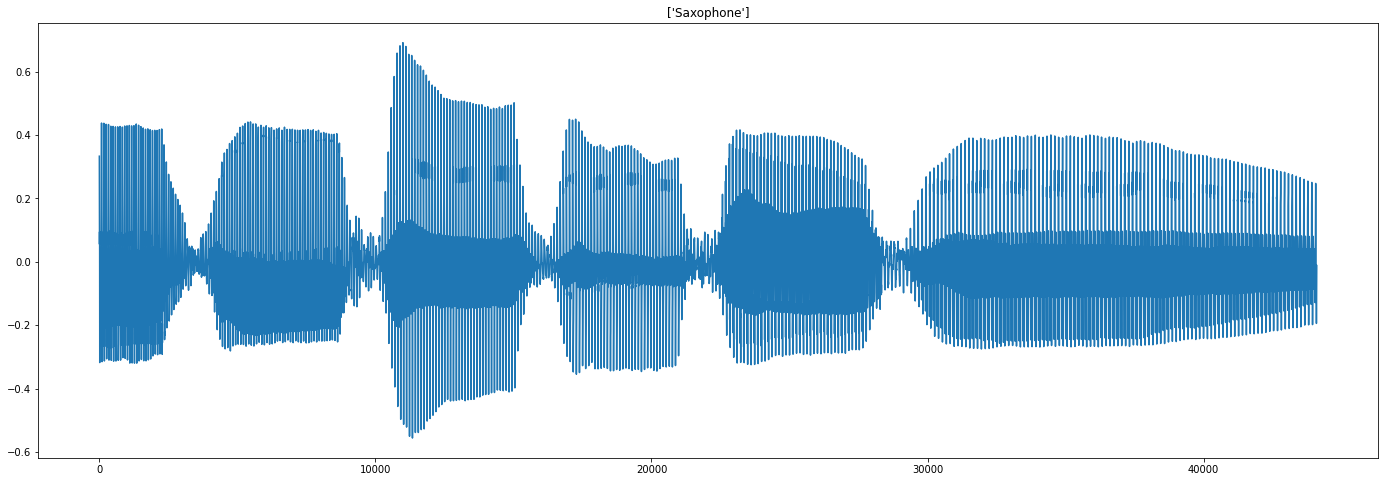

In [179]:
# Print a raw audio wave
plt.figure(figsize=(24,8))
plt.plot(generated_audio_waves[2])
plt.title(generated_audio_labels[2])
plt.show()


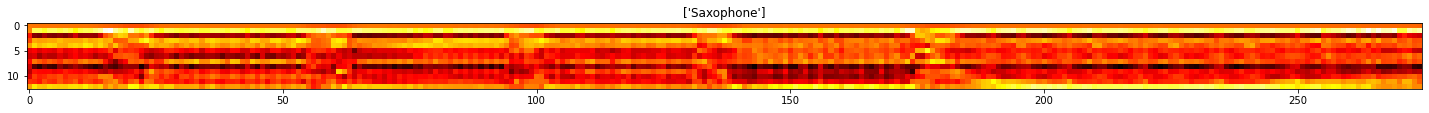

In [180]:
# Print the MFCC features of the audio wave
plt.figure(figsize=(25, 60))
plt.imshow(mfcc_features[2].T, cmap='hot')
plt.title(generated_audio_labels[2])
plt.show()


In [181]:
# Label encoding
label_encoder = LabelEncoder()
label_encoded = label_encoder.fit_transform(generated_audio_labels)
print(label_encoded)

label_encoded = label_encoded[:, np.newaxis]
print(label_encoded)

[2 1 3 ... 2 3 2]
[[2]
 [1]
 [3]
 ...
 [2]
 [3]
 [2]]


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [182]:
# One hot encoding
one_hot_encoder = OneHotEncoder(sparse=False)
one_hot_encoded = one_hot_encoder.fit_transform(label_encoded)
print(one_hot_encoded)


[[0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 ...
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]]


In [183]:
# Model training
X = mfcc_features
y = one_hot_encoded
X = (X-X.min())/(X.max()-X.min())
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)


In [184]:
# Defining input shape for the neural network
input_shape = (X_train.shape[1], X_train.shape[2],1 )

# Reshape X_train and X_test such that they are having the same shape as the input shape
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
print(X_train.shape)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2],1 )
print(X_test.shape)

(5457, 275, 13, 1)
(1820, 275, 13, 1)


In [185]:
 # Constructing the neural network architecture
model = Sequential()
model.add(Conv2D(16, (3, 3), activation='relu', strides=(1, 1), 
    padding='same', input_shape=input_shape))
model.add(Conv2D(32, (3, 3), activation='relu', strides=(1, 1), 
    padding='same'))
model.add(MaxPool2D((2, 2)))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(5, activation='softmax'))

model.compile(loss='categorical_crossentropy', 
     optimizer='adam',
     metrics=['acc'])






Epoch 1/35
273/273 [==============================] - 3s 8ms/step - loss: 1.3032 - acc: 0.4565 - val_loss: 0.9563 - val_acc: 0.6044
Epoch 2/35
273/273 [==============================] - 2s 6ms/step - loss: 1.0226 - acc: 0.6132 - val_loss: 0.8091 - val_acc: 0.7044
Epoch 3/35
273/273 [==============================] - 2s 6ms/step - loss: 0.9048 - acc: 0.6647 - val_loss: 0.7413 - val_acc: 0.7264
Epoch 4/35
273/273 [==============================] - 2s 6ms/step - loss: 0.8365 - acc: 0.6890 - val_loss: 0.6519 - val_acc: 0.7687
Epoch 5/35
273/273 [==============================] - 2s 6ms/step - loss: 0.7640 - acc: 0.7235 - val_loss: 0.6469 - val_acc: 0.7758
Epoch 6/35
273/273 [==============================] - 2s 7ms/step - loss: 0.7054 - acc: 0.7521 - val_loss: 0.5553 - val_acc: 0.7967
Epoch 7/35
273/273 [==============================] - 2s 6ms/step - loss: 0.6551 - acc: 0.7625 - val_loss: 0.5493 - val_acc: 0.8038
Epoch 8/35
273/273 [==============================] - 2s 6ms/step - loss: 0.

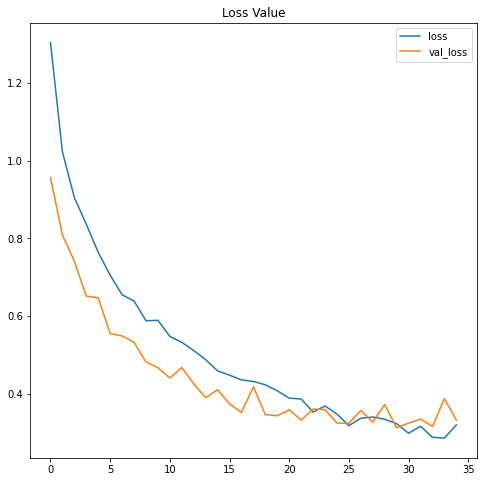

In [186]:
# Training the model
history = model.fit(X_train, y_train, epochs=35,batch_size=20, validation_data=(X_test, y_test))
# Displaying loss values
plt.figure(figsize=(8,8))
plt.title('Loss Value')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss', 'val_loss'])
print('loss:', history.history['loss'][-1])
print('val_loss:', history.history['val_loss'][-1])
plt.show()

acc: 0.8880337476730347
val_acc: 0.9054945111274719


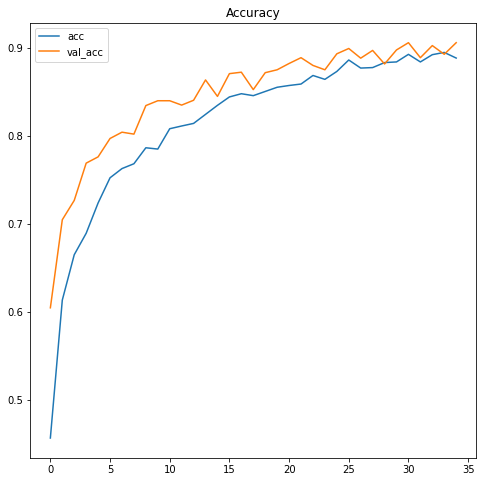

In [189]:
# Displaying accuracy scores
plt.figure(figsize=(8,8))
plt.title('Accuracy')
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.legend(['acc', 'val_acc'])
print('acc:', history.history['acc'][-1])
print('val_acc:', history.history['val_acc'][-1])
plt.show()

In [190]:
#Model evaluation
predictions = model.predict(X_test)

predictions = np.argmax(predictions, axis=1)
y_test = one_hot_encoder.inverse_transform(y_test)


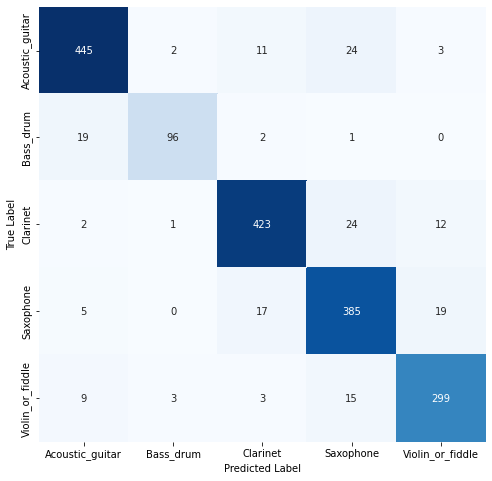

In [191]:
# Creating confusion matrix
cm = confusion_matrix(y_test, predictions)
plt.figure(figsize=(8,8))
sns.heatmap(cm, annot=True, xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_, fmt='d', cmap=plt.cm.Blues, cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [193]:
#saving the model in tensorflow format
path_tensorflow = '/content/variables/saved_model_tensorflow_format'
model.save(path_tensorflow)

In [194]:
#saving the model in hdf5 format
path_h5 = '/content/variables/save_model.h5'
model.save(path_h5)

In [195]:
#using the trained model for prediction by loading it 
new_model = tf.keras.models.load_model('/content/variables/save_model.h5') 